In [271]:
#Regression using neural networks
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [272]:
data = pd.read_csv("train.csv")
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [273]:
#preprocessing 1 : 범주형 데이터 변환 및 제거
#수치데이터들 입니다. 수치데이터로 변환 가능한 범주형 데이터들도 포함이 되어있습니다
#해당 데이터들은 이후에 수치형 데이터로 변환합니다.
num_feats = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 
             'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 
             'BsmtQual', 'BsmtCond', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
             'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
             'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
             'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
             'Fireplaces', 'FireplaceQu', 'GarageYrBlt',
             'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
             'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
             'ScreenPorch', 'PoolArea', 'PoolQC', 'MiscVal',
             'YrSold','SalePrice']

In [274]:
#범주형 데이터를 수치화시켜줍니다.
grade_feat = ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
          'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
grade_data = data[grade_feat]
data.shape

(1460, 81)

In [275]:
#문자로 된 범주를 수치로 변환합니다.
level = ['Ex', 'Gd', 'TA', 'Fa', 'Po']
num_level = [10, 8, 6, 4, 2]
changed = dict(zip(level, num_level))
#수치로 변환이 완료되면 원래 데이터와 교체합니다.
grade = grade_data.replace(changed)
grade.shape

(1460, 12)

In [276]:
data[grade_feat] = data[grade_feat].replace(changed)
data.shape

(1460, 81)

In [277]:
#범주형 데이터를 제거해줍니다.
#num_feats를 활용해서 범주형 데이터 선언.
cat_feats = data.drop(num_feats, axis=1).columns
#범주형 데이터 제거
data.drop(cat_feats,axis=1,inplace=True)
data.shape

(1460, 45)

In [278]:
#preprocessing 2 : 결측치 제거
data.isnull().sum()[data.isnull().sum() > 0]

LotFrontage     259
MasVnrArea        8
BsmtQual         37
BsmtCond         37
FireplaceQu     690
GarageYrBlt      81
GarageQual       81
GarageCond       81
PoolQC         1453
dtype: int64

In [279]:
#결측치의 개수가 상대적으로 많은 세가지 요소 LotFrontage, FireplaceQu, PoolQC를 제거합니다.
data.drop(['LotFrontage','FireplaceQu','PoolQC'],axis=1,inplace=True)

In [280]:
#결측치를 포함한 행을 제거합니다.
print(data.shape)
data.dropna(axis=0,how='any',inplace=True)
print(data.shape)

(1460, 42)
(1341, 42)


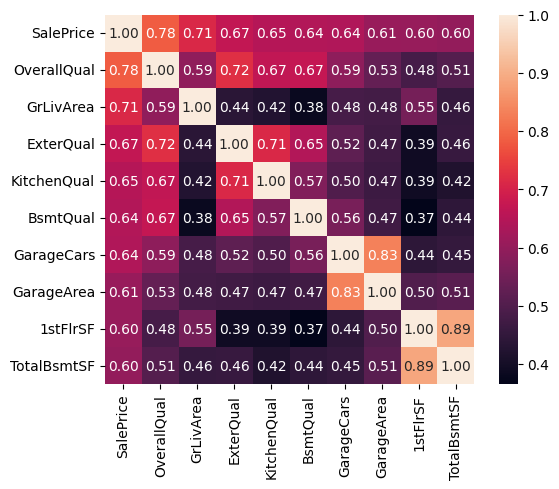

In [281]:
#feature selection
#변수들중 결과와 상관관계가 높은 9가지를 추출하였습니다.
corr = data.corr()
corr_ten = corr.nlargest(10,'SalePrice')['SalePrice']
corr_ten_idx = corr_ten.index
corr_mat = np.corrcoef(data[corr_ten_idx].values.T)
heatmap = sns.heatmap(corr_mat, cbar=True, annot=True, square=True, fmt='.2f'
                      ,yticklabels = corr_ten_idx.values,xticklabels = corr_ten_idx.values )
plt.show()

In [282]:
ndata = data[corr_ten_idx]
X = ndata[corr_ten_idx[1:10]]
y = ndata[[corr_ten_idx[0]]]

In [283]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
scalerX = MinMaxScaler()
scalerX.fit(X_train)
X_train_norm = scalerX.transform(X_train)
X_test_norm = scalerX.transform(X_test)
scalerY = MinMaxScaler()
scalerY.fit(y_train)
y_train_norm = scalerY.transform(y_train)
y_test_norm = scalerY.transform(y_test)

In [284]:
#모델 구조
model = Sequential()#순차 모델
model.add(Dense(60,activation = 'relu',input_shape = (9,)))#첫번째 은닉층과 입력층
model.add(Dense(60,activation = 'relu'))#두번째 은닉층, 뉴런 60개
model.add(Dense(30,activation = 'relu'))#세번째 은닉층, 뉴런 30개
model.add(Dense(1))#출력층
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 60)                600       
                                                                 
 dense_57 (Dense)            (None, 60)                3660      
                                                                 
 dense_58 (Dense)            (None, 30)                1830      
                                                                 
 dense_59 (Dense)            (None, 1)                 31        
                                                                 
Total params: 6121 (23.91 KB)
Trainable params: 6121 (23.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [285]:
#문제의 조건에 따라 손실함수와 평가 행렬 mae로 선정
model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
results = model.fit(X_train_norm,y_train_norm,validation_data = (X_test_norm,y_test_norm),epochs = 200, batch_size = 32)

Epoch 1/200
30/30 [==============================] - 0s 2ms/step - loss: 0.0177 - mae: 0.0929 - val_loss: 0.0060 - val_mae: 0.0474
Epoch 2/200
30/30 [==============================] - 0s 964us/step - loss: 0.0052 - mae: 0.0499 - val_loss: 0.0050 - val_mae: 0.0449
Epoch 3/200
30/30 [==============================] - 0s 880us/step - loss: 0.0042 - mae: 0.0443 - val_loss: 0.0048 - val_mae: 0.0415
Epoch 4/200
30/30 [==============================] - 0s 896us/step - loss: 0.0038 - mae: 0.0408 - val_loss: 0.0038 - val_mae: 0.0403
Epoch 5/200
30/30 [==============================] - 0s 897us/step - loss: 0.0032 - mae: 0.0373 - val_loss: 0.0034 - val_mae: 0.0389
Epoch 6/200
30/30 [==============================] - 0s 914us/step - loss: 0.0028 - mae: 0.0345 - val_loss: 0.0030 - val_mae: 0.0345
Epoch 7/200
30/30 [==============================] - 0s 919us/step - loss: 0.0027 - mae: 0.0341 - val_loss: 0.0029 - val_mae: 0.0336
Epoch 8/200
30/30 [==============================] - 0s 893us/step - lo

30/30 [==============================] - 0s 884us/step - loss: 0.0017 - mae: 0.0275 - val_loss: 0.0022 - val_mae: 0.0318
Epoch 63/200
30/30 [==============================] - 0s 913us/step - loss: 0.0015 - mae: 0.0259 - val_loss: 0.0020 - val_mae: 0.0286
Epoch 64/200
30/30 [==============================] - 0s 852us/step - loss: 0.0015 - mae: 0.0265 - val_loss: 0.0020 - val_mae: 0.0284
Epoch 65/200
30/30 [==============================] - 0s 841us/step - loss: 0.0015 - mae: 0.0258 - val_loss: 0.0026 - val_mae: 0.0367
Epoch 66/200
30/30 [==============================] - 0s 873us/step - loss: 0.0016 - mae: 0.0270 - val_loss: 0.0021 - val_mae: 0.0289
Epoch 67/200
30/30 [==============================] - 0s 839us/step - loss: 0.0016 - mae: 0.0257 - val_loss: 0.0021 - val_mae: 0.0285
Epoch 68/200
30/30 [==============================] - 0s 887us/step - loss: 0.0015 - mae: 0.0260 - val_loss: 0.0019 - val_mae: 0.0291
Epoch 69/200
30/30 [==============================] - 0s 860us/step - loss:

30/30 [==============================] - 0s 892us/step - loss: 0.0012 - mae: 0.0232 - val_loss: 0.0019 - val_mae: 0.0292
Epoch 124/200
30/30 [==============================] - 0s 872us/step - loss: 0.0012 - mae: 0.0233 - val_loss: 0.0021 - val_mae: 0.0293
Epoch 125/200
30/30 [==============================] - 0s 869us/step - loss: 0.0012 - mae: 0.0233 - val_loss: 0.0020 - val_mae: 0.0291
Epoch 126/200
30/30 [==============================] - 0s 855us/step - loss: 0.0012 - mae: 0.0235 - val_loss: 0.0021 - val_mae: 0.0299
Epoch 127/200
30/30 [==============================] - 0s 872us/step - loss: 0.0012 - mae: 0.0242 - val_loss: 0.0020 - val_mae: 0.0290
Epoch 128/200
30/30 [==============================] - 0s 868us/step - loss: 0.0013 - mae: 0.0255 - val_loss: 0.0020 - val_mae: 0.0289
Epoch 129/200
30/30 [==============================] - 0s 848us/step - loss: 0.0011 - mae: 0.0230 - val_loss: 0.0021 - val_mae: 0.0287
Epoch 130/200
30/30 [==============================] - 0s 850us/step 

30/30 [==============================] - 0s 882us/step - loss: 9.0307e-04 - mae: 0.0213 - val_loss: 0.0020 - val_mae: 0.0287
Epoch 184/200
30/30 [==============================] - 0s 909us/step - loss: 8.4420e-04 - mae: 0.0205 - val_loss: 0.0019 - val_mae: 0.0288
Epoch 185/200
30/30 [==============================] - 0s 841us/step - loss: 8.7495e-04 - mae: 0.0209 - val_loss: 0.0019 - val_mae: 0.0288
Epoch 186/200
30/30 [==============================] - 0s 860us/step - loss: 0.0012 - mae: 0.0238 - val_loss: 0.0024 - val_mae: 0.0336
Epoch 187/200
30/30 [==============================] - 0s 854us/step - loss: 0.0014 - mae: 0.0263 - val_loss: 0.0019 - val_mae: 0.0295
Epoch 188/200
30/30 [==============================] - 0s 855us/step - loss: 0.0010 - mae: 0.0223 - val_loss: 0.0019 - val_mae: 0.0291
Epoch 189/200
30/30 [==============================] - 0s 866us/step - loss: 9.2016e-04 - mae: 0.0214 - val_loss: 0.0020 - val_mae: 0.0294
Epoch 190/200
30/30 [==============================] 

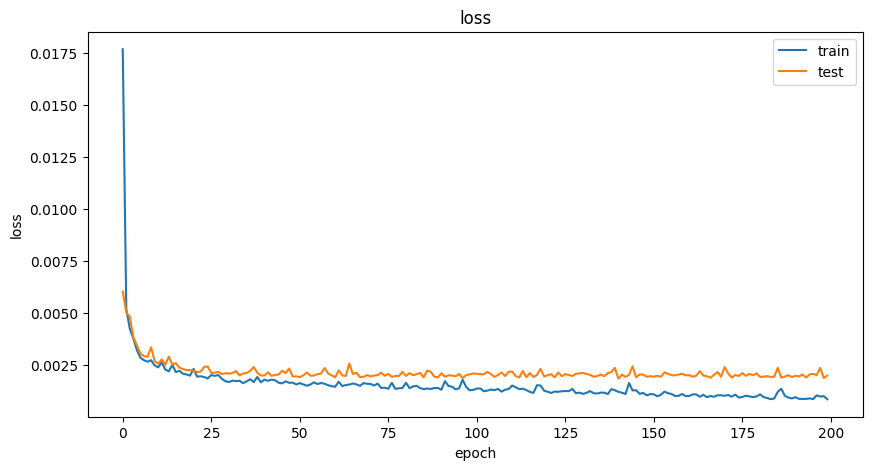

In [286]:
#학습 수에 따른 loss 변화
plt.figure(figsize = (10,5))
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','test'],loc='upper right')
plt.show()

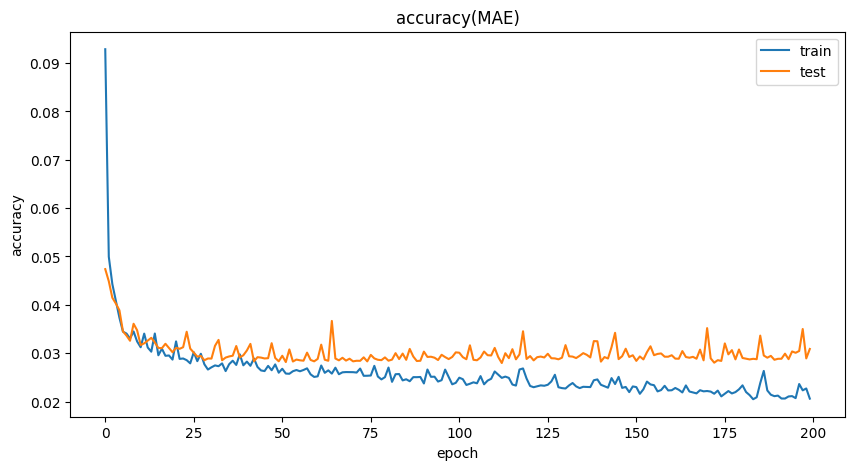

In [287]:
#학습 수에 따른 정확도(mae) 변화
plt.figure(figsize = (10,5))
plt.plot(results.history['mae'])
plt.plot(results.history['val_mae'])
plt.title('accuracy(MAE)')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'],loc='upper right')
plt.show()